## Введение

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

#### Библиотеки:

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

from functions import get_yd  # Самописная функция - используется для парсинга данных по ссылке Яндекс Диска

#### Входящие данные:
- **groups.csv** - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- **groups_add.csv** - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- **active_studs.csv** - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- **checks.csv** - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [4]:
groups_link = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_link = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_link = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_link = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [7]:
groups = pd.read_csv(get_yd(groups_link), sep=';')
groups_add = pd.read_csv(get_yd(groups_add_link), sep=',')
active_studs = pd.read_csv(get_yd(active_studs_link), sep=';')
checks = pd.read_csv(get_yd(checks_link), sep=';')

#### Вопросы, на которые нужно ответить:
1. На какие метрики Вы смотрите в ходе анализа и почему?
2. Имеются ли различия в показателях и с чем они могут быть связаны?
3. Являются ли эти различия статистически значимыми?
4. Стоит ли запускать новую механику на всех пользователей?

**Важно:** Уровень значимости для всех последующих тестов установим как 0.05

In [45]:
p_value = 0.05

## 0. Exploratory data analysis (EDA)

### Изначальное распределение пользователей.

In [46]:
# groups_add представляет собой часть пользователей А/Б тесте, которых добавили только спустя 2 дня.
# Так как структура и сущность этих данных полностью совпадает с groups, можно объединить эти данные.
# На всякий случая таже добавим мэппинг - primary и secondary.
groups['period'] = 'primary'
groups_add['period'] = 'secondary'
groups_full = pd.concat([groups, groups_add])

In [90]:
groups_full.head(5)

,id,grp,period
0,1489,B,primary
1,1627,A,primary
2,1768,B,primary
3,1783,B,primary
4,1794,A,primary


In [48]:
groups_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74576 entries, 0 to 91
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74576 non-null  int64 
 1   grp     74576 non-null  object
 2   period  74576 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


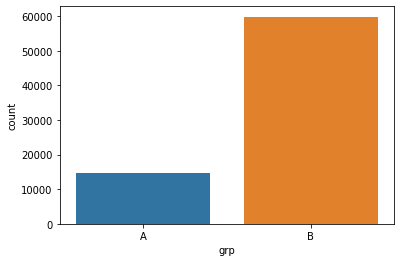

In [49]:
sns.countplot(data=groups_full, x='grp', order=['A', 'B'])

In [50]:
pd.concat({'number': groups_full.grp.value_counts(),
           'share': groups_full.grp.value_counts(normalize=True)}, axis=1)

,number,share
B,59883,0.80298
A,14693,0.19702


**Наблюдения:**
- Изначальное распределение пользователей по контрольной и тестовой группам неравномерное, однако в целом при таких условиях проводить эксперимент можно, если структуры пользователей в обеих группах равны (к примеру в обеих группах 30% пользователей из Москвы, а остальные из Питера).
- Главным недостатками такого подхода будут снижение силы теста и необходимость проведения тестирования дольше.
- Также важно учитывать, что аллокацию групп нельзя менять, пока идет тест

### Пользователи, зашедшие на сайт.

In [51]:
active_studs.head(5)

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [52]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [53]:
# Добавим распределение по группам
active_studs_by_groups = (active_studs
                          .merge(groups_full, how='left', left_on='student_id', right_on='id')
                          [['student_id', 'grp', 'period']])  # Исключаем дублированный id
active_studs_by_groups.head(5)

,student_id,grp,period
0,581585,A,primary
1,5723133,A,secondary
2,3276743,B,primary
3,4238589,A,primary
4,4475369,B,primary


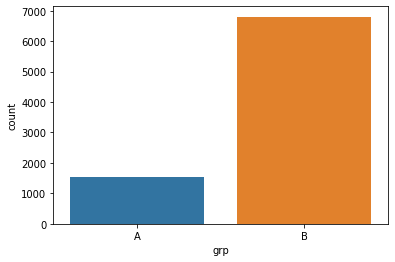

In [54]:
sns.countplot(data=active_studs_by_groups, x='grp')

In [55]:
pd.concat({'number': active_studs_by_groups.grp.value_counts(),
           'share': active_studs_by_groups.grp.value_counts(normalize=True)}, axis=1)

,number,share
B,6803,0.81561
A,1538,0.18439


**Наблюдения:** Распределение пользователей, зашедших на сайт во время проведения эксперимента, практически соответсвует изначально размеченным группам.

### Данные об оплате.

In [56]:
checks.head(5)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [57]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [58]:
checks.nunique()

student_id    541
rev            39
dtype: int64

In [59]:
checks_with_groups = checks.merge(groups_full, how='left', left_on='student_id', right_on='id')
checks_with_groups.head(5)

,student_id,rev,id,grp,period
0,1627,990.0,1627,A,primary
1,3185,690.0,3185,B,primary
2,25973,690.0,25973,B,primary
3,26280,690.0,26280,B,primary
4,100300,990.0,100300,B,primary


In [60]:
checks_with_groups.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 0 to 540
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
 2   id          541 non-null    int64  
 3   grp         541 non-null    object 
 4   period      541 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 25.4+ KB


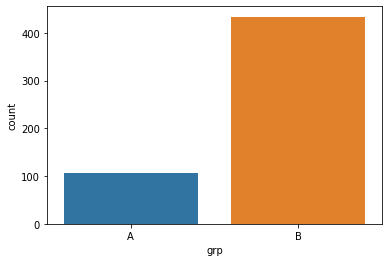

In [61]:
sns.countplot(data=checks_with_groups, x='grp')

In [62]:
pd.concat({'number': checks_with_groups.grp.value_counts(),
           'share': checks_with_groups.grp.value_counts(normalize=True)}, axis=1)

,number,share
B,434,0.802218
A,107,0.197782


**Наблюдения:** Распределение пользователей, совершивших оплату, соответсвует изначально размеченным группам.

### Распределение чеков.

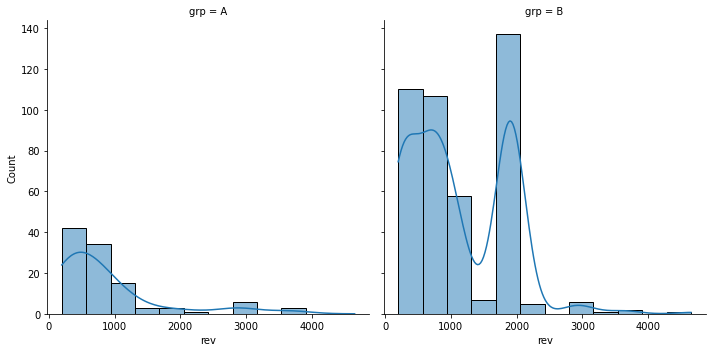

In [85]:
sns.displot(data=checks_with_groups, x='rev', col='grp', kde=True)

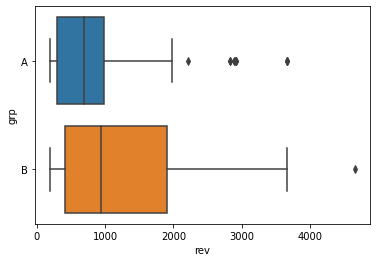

In [64]:
sns.boxplot(data=checks_with_groups, x='rev', y='grp')

In [65]:
control_values = checks_with_groups.query('grp == "A"').rev
test_values = checks_with_groups.query('grp == "B"').rev

In [66]:
# Тест на нормальность
shap_a = stats.shapiro(control_values)
shap_b = stats.shapiro(test_values)
print("Результаты теста Шапиро-Уилка:")
print(f"Контрольная группа - p: {shap_a[1]}")
print(f"Тестовая группа- p : {shap_b[1]}")

Результаты теста Шапиро-Уилка:
Контрольная группа - p: 5.321687643507211e-13
Тестовая группа- p : 8.947892893418603e-19


In [67]:
# Тест на равенство дисперсий
lev_res = stats.levene(control_values, test_values)
print("Результаты теста Левена:")
print(f"p-value: {lev_res[-1]}")
print(f"Дисперсии значительно отличаются друг от друга: {lev_res[-1] <= p_value}")

Результаты теста Левена:
p-value: 0.03477352573759214
Дисперсии значительно отличаются друг от друга: True


**Наблюдения:**
- Графики распределения и тест Шапиро-Уилка показывают, что распределения в обеих группах далеки от нормального.
- Согласно тесту Левена дисперсии значительно отличаются друг от друга
- Также в обеих группах присутствует ряд выбросов

### Логарифмическое распределение чеков.

Так как одно из главных требований для t-теста не выполняется (равенство дисперсий), мы может прологарифмировать значения, чтобы сгладить разброс между значениями (и заодно избавиться от выбросов).

In [68]:
checks_with_groups['rev_log'] = np.log(checks_with_groups.rev)

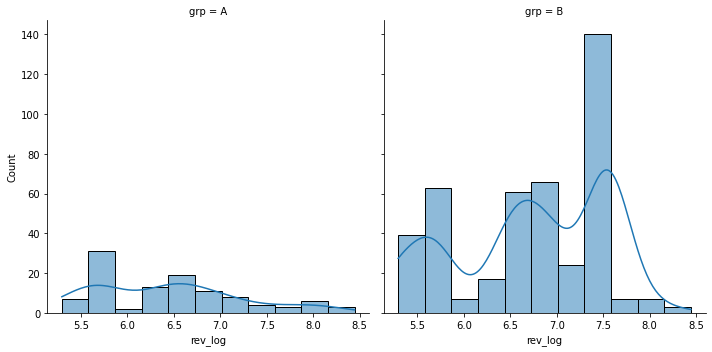

In [86]:
sns.displot(data=checks_with_groups, x='rev_log', col='grp', kde=True)

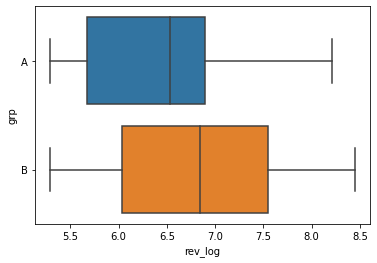

In [70]:
sns.boxplot(data=checks_with_groups, x='rev_log', y='grp')

In [71]:
control_values_log = checks_with_groups.query('grp == "A"').rev_log
test_values_log = checks_with_groups.query('grp == "B"').rev_log

In [72]:
# Тест на нормальность
shap_a = stats.shapiro(control_values_log)
shap_b = stats.shapiro(test_values_log)
print("Результаты теста Шапиро-Уилка:")
print(f"Контрольная группа - p: {shap_a[1]}")
print(f"Тестовая группа- p : {shap_b[1]}")

Результаты теста Шапиро-Уилка:
Контрольная группа - p: 8.370648174604867e-06
Тестовая группа- p : 9.436051588042332e-17


In [73]:
# Тест на равенство дисперсий
lev_res = stats.levene(control_values_log, test_values_log)
print("Результаты теста Левена:")
print(f"p-value: {lev_res[-1]}")
print(f"Дисперсии значительно отличаются друг от друга: {lev_res[-1] <= p_value}")

Результаты теста Левена:
p-value: 0.3026446230264329
Дисперсии значительно отличаются друг от друга: False


**Наблюдения:**
- Распределения все еще далеки от нормального
- Согласно тесту Левена дисперсии теперь статистически не отличаются друг от друга
- Выбросы пропали

## 1. На какие метрики Вы смотрите в ходе анализа и почему?

Изменение механики оплаты может повлиять прежде всего на **конверсию из захода на сайт в оплату**, так новая механика может упростить или усложнить процедуру оплаты для потенциального покупателя. В дополнение к этому может измениться **средний чек**, так как пользователям могут быть предложены новые условия, которые подтолкнут их к покупке более дорогих курсов или большего кол-ва курсов

## 2. Имеются ли различия в показателях и с чем они могут быть связаны?

### Конверсия.

In [74]:
# Проверяем, есть ли id зашедшего на сайт в датасете с покупками
active_studs_by_groups['conversion'] = active_studs_by_groups.student_id.isin(checks_with_groups.student_id)
active_studs_by_groups.head()

,student_id,grp,period,conversion
0,581585,A,primary,False
1,5723133,A,secondary,False
2,3276743,B,primary,False
3,4238589,A,primary,False
4,4475369,B,primary,False


In [75]:
# Преобразовываем датафрейм в кросс-таблицу
# Это также пригодится для дальнейшего статистического теста
conversion = pd.crosstab(active_studs_by_groups.grp, active_studs_by_groups.conversion)
conversion

conversion,False,True
grp,,
A,1460,78
B,6489,314


In [76]:
# Считаем конверсию в %
(conversion[True] / (conversion[True] + conversion[False]) * 100).round(2)

grp
A    5.07
B    4.62
dtype: float64

**Наблюдения**: конверсию в оплату для тестовой группы ниже на 0.45 процентных пунктов

### Средний чек.

In [77]:
check_avg = (
    checks_with_groups
    .groupby('grp', as_index=False)
    .agg({'rev': ['mean', 'median']})
    .transpose()
    .reset_index()
)
check_avg.columns = ['1', 'stat', 'control', 'test']
check_avg = check_avg.drop(0)[['stat', 'control', 'test']]
check_avg['dif'] = ((check_avg.test / check_avg.control - 1) * 100)

check_avg

,stat,control,test,dif
1,mean,860.71,1108.82,28.8267
2,median,690,935,35.5072


**Наблюдения**: средний чек в тестовой группе вырос на 28.8%, медианный чек - на 35,5%

**Общий вывод:** существенный рост среднего чека параллельно с падением конверсии может быть связан с расширением условий платежа (ввод рассрочки, бандлов и пр.)

## 3. Являются ли эти различия статистически значимыми?

### Конверсия.

In [78]:
conversion

conversion,False,True
grp,,
A,1460,78
B,6489,314


Так как данные по конверсии по сути представляют собой категориальные величины, лучшим выбором будет **критерий Хи-квадрат**. Два его главных условия выполняются: \
☑ Все наблюдения независимы \
☑ Количество наблюдений в каждой ячейке больше 5

In [79]:
conv_results = stats.chi2_contingency(conversion)

print("Тест Хи-квадрат:")
print(f"p-value: {conv_results[1]}")
print(f"Частота в обеих группах значительно отличается: {conv_results[1] <= p_value}")

Тест Хи-квадрат:
p-value: 0.48625240457231045
Частота в обеих группах значительно отличается: False


**Наблюдения**: разница конверсии в двух группах не являются статистически значимой, так как p-value превышает установленный порог.

### Средний чек.

In [80]:
checks_with_groups.head()

,student_id,rev,id,grp,period,rev_log
0,1627,990.0,1627,A,primary,6.897705
1,3185,690.0,3185,B,primary,6.536692
2,25973,690.0,25973,B,primary,6.536692
3,26280,690.0,26280,B,primary,6.536692
4,100300,990.0,100300,B,primary,6.897705


Для анализа данных по чекам будет использован t-тест на прологарифмированных данных. В таком случаем все три условия теста будут выполняться: \
☑ Равенство дисперсий \
☑ Нормальность распределения метрики (средняя) \
☑ Независимость событий

In [81]:
check_results = stats.ttest_ind(control_values_log, test_values_log)
print("t-тест Стьюдента:")
print(f"p-value: {check_results[1]}")
print(f"Средние в обеих группах значительно отличается: {check_results[1] <= p_value}")

t-тест Стьюдента:
p-value: 0.0004482400492255433
Средние в обеих группах значительно отличается: True


**Наблюдения:** разница среднего чека в двух группах являются статистически значимой, так как p-value значительно меньше установленного порога.

**Общий вывод:** статистика покзаала, что внедрение новой механики оплаты услуг приводит к росту среднего чека на 28.8% или более.

## 4. Стоит ли запускать новую механику на всех пользователей?

Текущие данные показывают, что новую механику нужно внедрять. При этом у нас нет возможности проверить ряд факторов:
- Независимость событий
- Репрезентативность двух выборок
- Достаточная длительность эксперимента